# 🐧 Ornithological Potential 🐦
### **Author:** Pablo Jusim

# 1️⃣ **Main Modelling Script**


In this notebook, you will find the **creation**, **training**, and **evaluation** of the machine learning model.

**Note:** This project is designed to be adaptable for any region worldwide. Tierra del Fuego Province is used here as an example case study.

# **2️⃣ Context**
This project uses a single notebook as the main workflow entry point. All specific tasks — such as preprocessing, grid generation, merging sources, and post-processing — are handled through custom Python modules stored in separate .py scripts (e.g., utils.py, grid_generation.py).

➡️ These scripts ensure that the entire pipeline is reproducible, well-structured, and easy to maintain.

➡️ The final output of the modelling process is a spatial grid that can be visualised as a interactive map. Besides, the spatial grid can be exported and further styled using GIS tools such as QGIS.


# 3️⃣ **Imports**

In [11]:
# Install specific Python module
%pip install -e ..

Obtaining file:///C:/Users/pablo/OneDrive/Estudio/Tecnicatura%20Cs%20datos%20e%20IA/3er%20cuatri/Aprendizaje%20autom%C3%A1tico/Parcial/Proyecto%20final/ornithological_potential
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ornithological-potential (pyproject.toml): started
  Building editable for ornithological-potential (pyproject.toml): finished with status 'done'
  Created wheel for ornithological-potential: filename=ornithological_potential-0.0.1-py3-none-any.whl size=5322 sha256=4724c51d221f35fb5e313f7ba15b830aad873

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from pathlib import Path

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.preprocessing import  normalize, StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from ornithological_potential import (
    utils,
    etl_ebird,
    etl_inat,
    grid_generation,
    merge_sources,
    postprocess_grid,
    export_interactive_map
)

## Project Modules Overview

Below is a brief description of the custom modules used in this project:

- **`utils.py`**: Contains utility functions for data preprocessing, evaluation metrics, and visualization helpers.

- **`etl_ebird.py`**: Handles extraction and transformation of eBird data, including cleaning and formatting.

- **`etl_inat.py`**: Contains functions to import and process iNaturalist data sources.

- **`grid_generation.py`**: Provides scripts to create and manage spatial grids for spatial analysis and mapping.

- **`merge_sources.py`**: Implements logic to combine and unify datasets from various biodiversity data sources.

- **`postprocess_grid.py`**: Includes post-processing functions for spatial grids, such as enrichment and clustering.

- **`export_interactive_map.py`**: Contains functions to generate and export interactive maps using Folium.


# 4️⃣ **Data Loading and General Configuration**

## Data Paths
Update these to your own paths.

### Base Directory

In [2]:
BASE_DIR = Path().resolve().parent

### Input Data Paths

In [3]:
# Path to eBird data
PATH_DATA_EBIRD = BASE_DIR / 'data' / 'external' / 'ebird_obs.txt'

# Path to iNaturalist data
PATH_DATA_INAT = BASE_DIR / 'data' / 'external' / 'inat_obs.csv'

# Path to contour file defining grid limits
CONTOUR_PATH = BASE_DIR / 'data' / 'external' / 'contour_tdf.gpkg'

### Output Data Paths

In [4]:
# Path to export the spatial grid file for use in GIS systems
PATH_SPATIAL_GRID = BASE_DIR / 'data' / 'processed' / 'richness_grid.gpkg'

# Path to export the interactive map HTML file
PATH_INTERACTIVE_MAP = BASE_DIR / 'data' / 'interim' / 'interactive_map.html'

## General Parameters
Adjust these values as needed.

In [5]:
# EPSG code for the coordinate reference system
EPSG_CODE = 4326  # WGS 84

# Grid cell side lenght in kilometers
CELL_SIZE = 5

# Maximum acceptable positional accuracy for iNaturalist observations (in meters)
MAX_ACCURACY = CELL_SIZE / 2


## Load Data

In [6]:
data_ebird = etl_ebird.main(Path(PATH_DATA_EBIRD))  # Load and clean eBird data
data_inat = etl_inat.main(Path(PATH_DATA_INAT))  # Load and clean iNaturalist data

2025-07-14 10:56:31,022 [INFO] Loaded 426837 raw eBird records from C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\ornithological_potential\data\external\ebird_obs.txt
2025-07-14 10:56:31,043 [INFO] Selected and renamed columns: ['common_name', 'scientific_name', 'latitude', 'longitude', 'observed_on']
2025-07-14 10:56:31,520 [INFO] Exported cleaned data to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\ornithological_potential\data\raw\data_ebird.csv
2025-07-14 10:56:31,591 [INFO] Loaded 15651 raw iNaturalist records from C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\ornithological_potential\data\external\inat_obs.csv
2025-07-14 10:56:31,594 [INFO] Filtered by accuracy < 2500m: 8087 records remain
2025-07-14 10:56:31,598 [INFO] Normalized scientific names to genus and species
2025-07

# 5️⃣ **Database Setup for Modeling**

## Create Spatial Grid
Generate a spatial grid of `CELL_SIZE × CELL_SIZE` km clipped to the user-defined study area.

In [7]:
grid_generation.main(
    contour_path=CONTOUR_PATH,
    epsg_code=EPSG_CODE,
    cell_size=CELL_SIZE
    )

2025-07-14 10:56:31,632 [INFO] Loaded contour: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\ornithological_potential\data\external\contour_tdf.gpkg
2025-07-14 10:56:31,647 [INFO] Generated 2484 grid points
2025-07-14 10:56:32,053 [INFO] Filtered to 916 cells within contour
2025-07-14 10:56:32,070 [INFO] Created 916 records
2025-07-14 10:56:32,084 [INFO] Grid exported to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\ornithological_potential\data\raw\empty_local_grid.gpkg


## Build Unified Observations DataFrame
Combine cleaned eBird and iNaturalist records and assign each to its grid cell.

In [8]:
merge_sources.main()

2025-07-14 10:56:32,090 [ERROR] Input file not found: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\data\raw\data_ebird.csv


SystemExit: 1

C:\Users\pablo\AppData\Roaming\Python\Python313\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 6️⃣ **Data Exploration & Preprocessing**

## Load Unified & Gridded Dataset 

In [ ]:
MERGED_DATA_PATH = BASE_DIR / 'data' / 'interim' / 'species_grid.CSV'

try:
    df = pd.read_csv(MERGED_DATA_PATH)
    print(f"Loaded merged data: {MERGED_DATA_PATH}")
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {MERGED_DATA_PATH}")

Loaded merged data: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\interim\species_grid.CSV


## Exploratory Metrics

### Data Shape & Columns

In [ ]:
n_cells, n_cols = df.shape
print(f"Number of cells: {n_cells}")
print(f"Number of columns (including grid_id): {n_cols}")
print("Columns:", df.columns.tolist())

Number of cells: 393
Number of columns (including grid_id): 179
Columns: ['grid_id', 'Anairetes parulus', 'Anarhynchus falklandicus', 'Anas bahamensis', 'Anas flavirostris', 'Anas georgica', 'Anser anser', 'Anthus correndera', 'Aphrastura spinicauda', 'Aptenodytes patagonicus', 'Ardea ibis', 'Ardenna gravis', 'Ardenna grisea', 'Arenaria interpres', 'Asio flammeus', 'Asthenes anthoides', 'Astur chilensis', 'Attagis malouinus', 'Bubo magellanicus', 'Buteo ventralis', 'Calidris alba', 'Calidris bairdii', 'Calidris canutus', 'Calidris fuscicollis', 'Calidris himantopus', 'Calidris melanotos', 'Calidris pusilla', 'Calidris virgata', 'Campephilus magellanicus', 'Caracara plancus', 'Cathartes aura', 'Charadrius semipalmatus', 'Chionis albus', 'Chloephaga hybrida', 'Chloephaga picta', 'Chloephaga poliocephala', 'Chloephaga rubidiceps', 'Chroicocephalus maculipennis', 'Cinclodes antarcticus', 'Cinclodes fuscus', 'Cinclodes oustaleti', 'Cinclodes patagonicus', 'Circus cinereus', 'Cistothorus pla

### Per-Cell Metrics
Compute:
- **total_records:** total observations per cell
- **richness:** number of species with at least one record

In [ ]:
species_cols = df.columns.drop('grid_id')
df['total_records'] = df[species_cols].sum(axis=1)
df['richness']      = (df[species_cols] > 0).sum(axis=1)

# Preview first rows
df[['grid_id', 'total_records', 'richness']].head()

,grid_id,total_records,richness
0,25,170,48
1,26,189,51
2,27,179,57
3,28,19,19
4,70,555,70


### Richness Summary Statistics

In [ ]:
print("Mean richness:  ", df['richness'].mean())
print("Median richness:", df['richness'].median())
print("Min richness:   ", df['richness'].min())
print("Max richness:   ", df['richness'].max())

Mean richness:   27.41730279898219
Median richness: 19.0
Min richness:    1
Max richness:    144


**Note:** If the median is lower than the mean, it suggests a few cells have exceptionally high species counts.

## Exploratory Plots

#### Distribution of Total Records per Cell

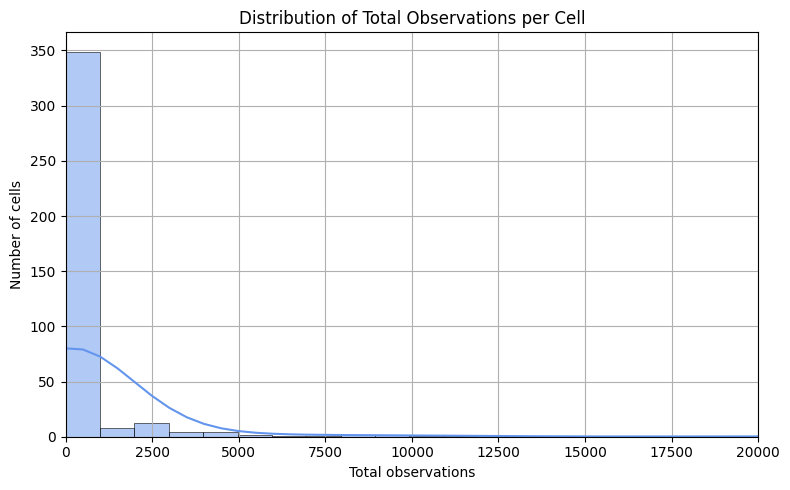

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df['total_records'],
    bins=100,
    kde=True,
    color='cornflowerblue'
)
plt.xlim(0, 20000)
plt.title("Distribution of Total Observations per Cell")
plt.xlabel("Total observations")
plt.ylabel("Number of cells")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Distribution of Species Richness per Cell

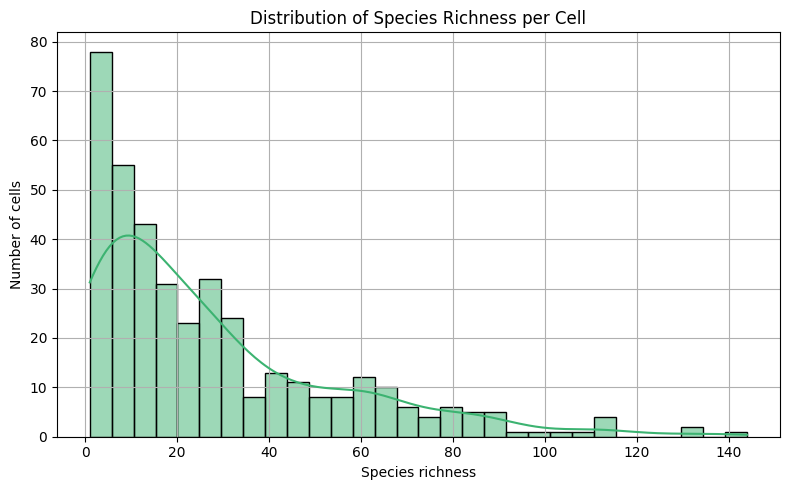

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df['richness'],
    bins=30,
    kde=True,
    color='mediumseagreen'
)
plt.title("Distribution of Species Richness per Cell")
plt.xlabel("Species richness")
plt.ylabel("Number of cells")
plt.grid(True)
plt.tight_layout()
plt.show()


## Remove Extremely Rare or Ubiquitous Species
Cells where a species occurs in **< 2 %** or **> 90 %** of grid cells are considered unusually rare or overly ubiquitous. We remove them to improve clustering performance. The lower and upper thresholds can be modified.


In [ ]:
# Set lower and upper thresholds for species frequency
LOWER_THRESHOLD = 0.02
UPPER_THRESHOLD = 0.90

df_idx = df.set_index('grid_id')  # use grid_id as index
relative_freq = (df_idx > 0).sum(axis=0) / len(df_idx)

# Keep only species with relative frequency between the thresholds
useful_species = relative_freq[
    (relative_freq >= LOWER_THRESHOLD) &
    (relative_freq <= UPPER_THRESHOLD)
].index
df_filtered = df_idx[useful_species]

## TF–IDF Transformation and Row Normalization
Apply TF–IDF to emphasize rare species and downweight very common ones, then normalize each cell vector (row) to unit length so that cosine-based clustering works properly.

In [ ]:
# TF–IDF transform (no row normalization yet)
X1 = df_filtered.values  # shape = (n_cells, n_species)
tfidf = TfidfTransformer(norm=None, use_idf=True, smooth_idf=True)
X_tfidf = tfidf.fit_transform(X1).toarray()

# L2 normalize each row for cosine distance
X_norm = normalize(X_tfidf, norm='l2', axis=1)

# Wrap back into DataFrame for convenience
df_tfidf = pd.DataFrame(
    X_norm,
    index=df_filtered.index,  # original grid_id
    columns=df_filtered.columns  # species names
)


df_tfidf.head()


,Anairetes parulus,Anarhynchus falklandicus,Anas bahamensis,Anas flavirostris,Anas georgica,Anthus correndera,Aphrastura spinicauda,Aptenodytes patagonicus,Ardea ibis,Ardenna gravis,...,Tringa melanoleuca,Troglodytes musculus,Turdus falcklandii,Tyto furcata,Upucerthia dumetaria,Vanellus chilensis,Vultur gryphus,Zenaida auriculata,Zonibyx modestus,Zonotrichia capensis
grid_id,,,,,,,,,,,,,,,,,,,,,
25,0.000000,0.0,0.0,0.000000,0.019785,0.021280,0.000000,0.000000,0.0,0.150185,...,0.0,0.019331,0.017067,0.0,0.0,0.034545,0.019523,0.0,0.023789,0.014640
26,0.127041,0.0,0.0,0.089137,0.095427,0.034213,0.157463,0.000000,0.0,0.000000,...,0.0,0.155400,0.137202,0.0,0.0,0.055540,0.000000,0.0,0.076495,0.117688
27,0.000000,0.0,0.0,0.026418,0.056565,0.060841,0.084003,0.049078,0.0,0.107347,...,0.0,0.082903,0.073195,0.0,0.0,0.049383,0.083726,0.0,0.068014,0.062784
28,0.274709,0.0,0.0,0.000000,0.000000,0.000000,0.204295,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.248116,0.152691
70,0.014261,0.0,0.0,0.070043,0.149971,0.138264,0.042423,0.000000,0.0,0.020329,...,0.0,0.146534,0.138615,0.0,0.0,0.074816,0.000000,0.0,0.025761,0.110973


# 7️⃣ **Modeling**

## Prepare Data for Storing Model Outputs 

In [ ]:
EMPTY_GRID_PATH = BASE_DIR / 'data' / 'raw' / 'empty_local_grid.gpkg'

# Copy the TF–IDF DataFrame so we don’t overwrite the preprocessed data
X = df_tfidf.copy()
# Store the grid cell IDs
id_grid = X.index

# Load the empty spatial grid
gdf_grid = gpd.read_file(EMPTY_GRID_PATH)

## Model Building & Training
Train three models and select the best one for the data.

### K-means

#### Select Optimal Number of Clusters

In [ ]:
scores = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    scores[k] = silhouette_score(X, km.labels_)

best_k = max(scores, key=scores.get)
print(f'Best number of clusters: {best_k}')

Best number of clusters: 4


#### Fit model

In [ ]:
model_km = KMeans(n_clusters=best_k, random_state=0).fit(X)
labels_km = model_km.labels_

### Gaussian Mixture

#### Select optimal cluster number

In [ ]:
df_bic, best_k_gaus = utils.select_best_k(
    X,
    model_class=GaussianMixture,
    k_range=range(1, 10),
    model_kwargs={'covariance_type': 'full'},
    scoring='bic'
)

print(f'Best number of clusters: {best_k_gaus}')

Best number of clusters: 3


#### Fit model

In [ ]:
n_components = best_k_gaus
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',
    random_state=0
)
gmm.fit(X)
labels_gmm = gmm.predict(X)

### Spectral Clustering

#### Select optimal cluster number

In [ ]:
df_sil, best_k_spec = utils.select_best_k(
    X,
    model_class=SpectralClustering,
    k_range=range(1, 10),
    model_kwargs={'affinity':'nearest_neighbors',
                  'n_neighbors': 10,
                  'assign_labels': 'kmeans'},
    scoring='silhouette'
)

print(f'Best number of clusters: {best_k_spec}')

Best number of clusters: 3


#### Fit model

In [ ]:
sp = SpectralClustering(
    n_clusters=best_k_spec,
    affinity='nearest_neighbors',
    n_neighbors=10,
    assign_labels='kmeans',
    random_state=0
)
labels_sp = sp.fit_predict(X)

## Model Evaluation
Since these are unsupervised clustering algorithms, we use internal validation metrics rather than comparing against ground‑truth labels.

### Silhouette Score
- Measures how well each point fits within its cluster vs. the next nearest cluster.  
- Range: -1 to 1; higher values indicate better separation. 

In [ ]:
# K-means
silhouette_km = silhouette_score(X, labels_km)
print(f'silhouette para k-means: {silhouette_km}')

# Gaussian Mixture
silhouette_gmm = silhouette_score(X, labels_gmm)
print(f'silhouette para gausiano: {silhouette_gmm}')

# Spectral Clustering
silhouette_sp = silhouette_score(X, labels_sp)
print(f'silhouette para espectral: {silhouette_sp}')

# Collect all
silhouette_scores = [silhouette_km, silhouette_gmm, silhouette_sp]

silhouette para k-means: 0.10211902478889852
silhouette para gausiano: 0.09380874687452652
silhouette para espectral: 0.0985471185823684


### Davies-Bouldin Index
- Evaluates cluster separation and compactness.
- Lower values are better.

In [ ]:
# K‑means
db_km = davies_bouldin_score(X, labels_km)
print(f"Davies-Bouldin (K-means): {db_km:.3f}")

# Gaussian Mixture
db_gmm = davies_bouldin_score(X, labels_gmm)
print(f"Davies-Bouldin (GMM):          {db_gmm:.3f}")

# Spectral Clustering
db_sp = davies_bouldin_score(X, labels_sp)
print(f"Davies-Bouldin (Spectral):     {db_sp:.3f}")

# Collect all
db_scores = [db_km, db_gmm, db_sp]

Davies-Bouldin (K-means): 3.178
Davies-Bouldin (GMM):          3.059
Davies-Bouldin (Spectral):     2.828


### Calinski-Harabasz Index
- Ratio of between‑cluster dispersion to within‑cluster dispersion.
- Higher values indicate more distinct clusters.

In [ ]:
# K‑means
ch_km = calinski_harabasz_score(X, labels_km)
print(f"Calinski-Harabasz (K-means):      {ch_km:.3f}")

# Gaussian Mixture
ch_gmm = calinski_harabasz_score(X, labels_gmm)
print(f"Calinski-Harabasz (GMM):          {ch_gmm:.3f}")

# Spectral Clustering
ch_sp = calinski_harabasz_score(X, labels_sp)
print(f"Calinski-Harabasz (Spectral):     {ch_sp:.3f}")

# Collect all
ch_scores = [ch_km, ch_gmm, ch_sp]


Calinski-Harabasz (K-means):      28.664
Calinski-Harabasz (GMM):          31.218
Calinski-Harabasz (Spectral):     30.829


### Combined Scoring
We invert Davies‑Bouldin (so higher is better), normalize all three metrics with StandardScaler, and take their average. The model with the highest combined score wins.

In [ ]:
# Invert Davies‑Bouldin so that higher is better
db_inv = [-x for x in db_scores]

# Stack metrics: [silhouette, inverted DB, Calinski-Harabasz]
metrics = np.vstack([silhouette_scores, db_inv, ch_scores]).T

# Normalize each column to [0,1]
scaler = StandardScaler()
metrics_norm = scaler.fit_transform(metrics)

# Compute the average score per model
total_scores = metrics_norm.mean(axis=1)


print(f"K-means           : {total_scores[0]:.3f}")
print(f"Gaussian Mixture  : {total_scores[1]:.3f}")
print(f"Spectral Clustering: {total_scores[2]:.3f}")

K-means           : -0.437
Gaussian Mixture  : -0.221
Spectral Clustering: 0.658


### Select best model

In [ ]:
best_idx = np.argmax(total_scores)
if best_idx == 0:
    best_model_name = 'K-means'
    labels_model     = labels_km
elif best_idx == 1:
    best_model_name = 'Gaussian Mixture'
    labels_model     = labels_gmm
else:
    best_model_name = 'Spectral Clustering'
    labels_model    = labels_sp

print(f"------------------------------------------")
print(f"Best model: {best_model_name}")

------------------------------------------
Best model: Spectral Clustering


# 8️⃣ **Model Results Plots**

## Data preparation
Merge cluster assignments back into the main observations DataFrame. 

In [ ]:
# Build a DataFrame of cluster labels
df_clusters = pd.DataFrame({
    'grid_id': id_grid,
    'cluster': labels_model
})

# Join cluster labels to the main data
df_c = df.merge(df_clusters, on='grid_id', how='left')


## Richness by Cluster

2025-07-04 10:43:16,255 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-04 10:43:16,259 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


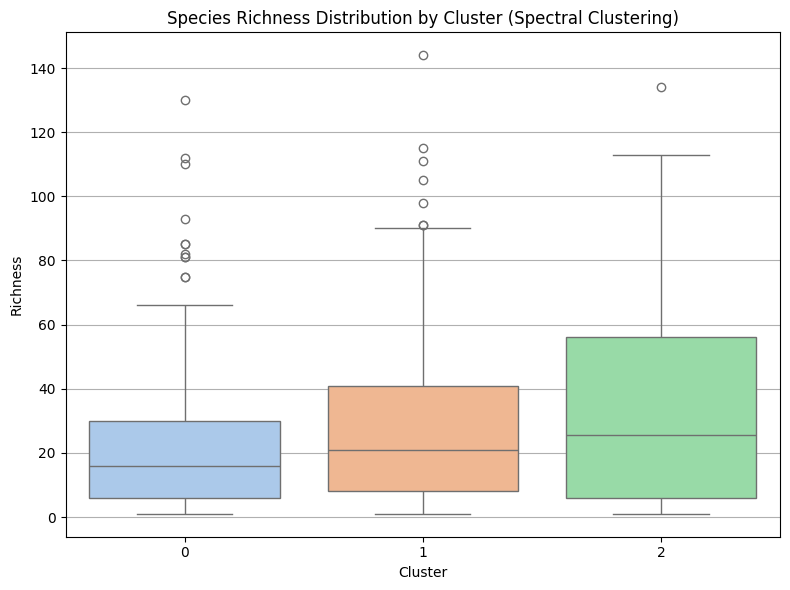

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_c,
    x="cluster",
    y="richness",
    hue="cluster",
    palette="pastel",
    legend=False
)
plt.title(f"Species Richness Distribution by Cluster ({best_model_name})")
plt.xlabel("Cluster")
plt.ylabel("Richness")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

## Cell Counts by Cluster
Bar chart of number of grid cells per cluster.

2025-07-04 10:43:16,356 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-04 10:43:16,360 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


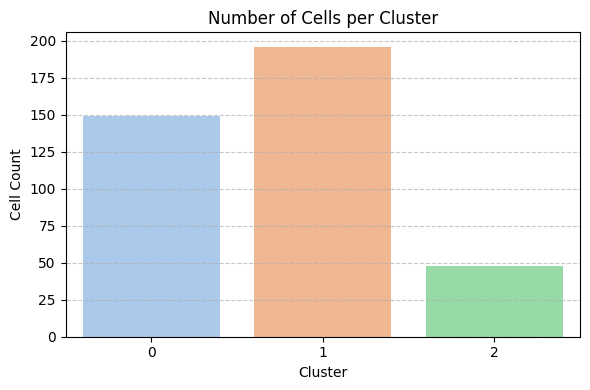

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(
    data=df_c,
    x="cluster",
    hue="cluster",
    palette="pastel",
    legend=False
)
plt.title("Number of Cells per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Cell Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 9️⃣ **Estimate Richness Score per Cell & Export Spatial Grid**
The score for each cell is computed by summing the number of species recorded there, 
optionally giving extra weight to certain “priority” species. Then we normalize so that 
the cell with the highest raw richness in each cluster has a score of 1, and all other 
cells in that cluster get a score proportional to their richness relative to that maximum.

## Priority Species List
Define any species to up‑weight in the richness scoring (e.g., endemic, charismatic or threatened species). Leave the list empty to apply equal weight. Use binomial names exactly, e.g. **"Canis familiaris"**.


In [ ]:
# List of species to prioritise when scoring
PRIORITY_SPECIES = [
            "Campephilus magellanicus", "Vultur gryphus", "Chloephaga hybrida",
            "Chloephaga rubidiceps", "Daptrius albogularis",
            "Daptrius australis", "Cinclodes antarcticus",
            "Tachyeres pteneres", "Geositta antarctica",
            "Calidris canutus", "Aptenodytes patagonicus",
            "Thalassarche melanophris"
    ]

# Assign weight to each priority species
PRIORITY_WEIGHT = 2

## Export Spatial Grid with Model Results
Merge the cluster labels into the spatial grid and save as a GeoPackage for GIS use.

In [ ]:
# Merge model clusters into the grid GeoDataFrame
gdf_grid = utils.merge_model_results(
    grid_gdf=gdf_grid,
    cell_ids=id_grid,
    cluster_labels=labels_model,
    model_name=best_model_name
)

SPECIES_GRID_PATH = BASE_DIR / 'data' / 'interim' / 'species_grid.gpkg'

# Save the enriched grid
gdf_grid.to_file(SPECIES_GRID_PATH, driver="GPKG", layer="clusters_grid")
print(f"Spatial grid with clusters saved to: {SPECIES_GRID_PATH}")

2025-07-04 11:05:45,646 [INFO] Created 916 records
Spatial grid with clusters saved to: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\interim\species_grid.gpkg


## Automated Pipeline Call
Run the end‑to‑end post‑processing function to compute weighted richness, normalise scores and export the grid

In [ ]:
postprocess_grid.main(
    grid_path=SPECIES_GRID_PATH,
    layer='clusters_grid',
    export_path=Path(PATH_SPATIAL_GRID),
    priority_species=PRIORITY_SPECIES,
    priority_weight=PRIORITY_WEIGHT,

)

2025-07-04 11:05:53,157 [INFO] Loaded grid: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\interim\species_grid.gpkg
2025-07-04 11:05:53,161 [INFO] Loaded counts: 393 rows


c:\Users\pablo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\geopandas.py:265: UserWarning: More than one layer found in 'species_grid.gpkg': 'grilla_clusters' (default), 'clusters_grid'. Specify layer parameter to avoid this warning.
  result = read_func(


KeyError: "['GaussianMixture'] not in index"

# 🔟 **Obtain & Display Interactive Map**
Use the selected model’s clustering results to generate the final Folium map.  
This will write the HTML file to `PATH_INTERACTIVE_MAP` and render it inline.

In [ ]:
# Generate and display the interactive map
interactive_map = export_interactive_map.main(
    export_path=PATH_INTERACTIVE_MAP,
    cluster_count=best_idx
)

# Render the map in the notebook
interactive_map

2025-07-01 10:24:49,778 [INFO] Loaded enriched grid: C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\data\processed\grilla_riqueza.gpkg


c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\export_interactive_map.py:73: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs.geometry.centroid.y.mean(),
c:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\notebooks\..\src\export_interactive_map.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs.geometry.centroid.x.mean()


2025-07-01 10:24:50,065 [INFO] Saved interactive map to C:\Users\pablo\OneDrive\Estudio\Tecnicatura Cs datos e IA\3er cuatri\Aprendizaje automático\Parcial\Proyecto final\Potencial-ornitologico-fueguino\reports\figures\interactive_map.html
